## Dynamics of self-organizing particles

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, sys
import time

import torch
import torch.nn as nn
import torch.optim as optim

from torch_geometric.data import Data, Batch
from torch_geometric.utils import degree
from torch_geometric.transforms import Distance

from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema

sys.path.append('../..')
from display import cm, format_axis, format_str, props
from ode import ODEGraph, Swarm
from cxs import CXSPoint

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
default_type = torch.float32
torch.set_default_dtype(default_type)

In [3]:
image_dir = '_images/'
model_dir = '_models/'

if not os.path.exists(image_dir):
    os.makedirs(image_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Simulate time series data

In [4]:
method = 'dopri5'
adjoint = False

args = {'N': 500,
        'L': 5.,
        'D': 2,
        'R': 0.15,
        'J': 0.,
        'K': 0.,
        'rc': 0.75,
        'Nc': 500,
        'fc': 'tanh'
       }
M = 50

swarm = Swarm(args, method, default_type)
swarm.init_state(M)
swarm.to(device)

tf = 10
T = 10*tf + 1
t = torch.linspace(0, tf, T)
print('T:', T)

swarm.solve(t, device=device, rtol=1e-6, atol=1e-6)

T: 101
Elapsed time: 2.66 s


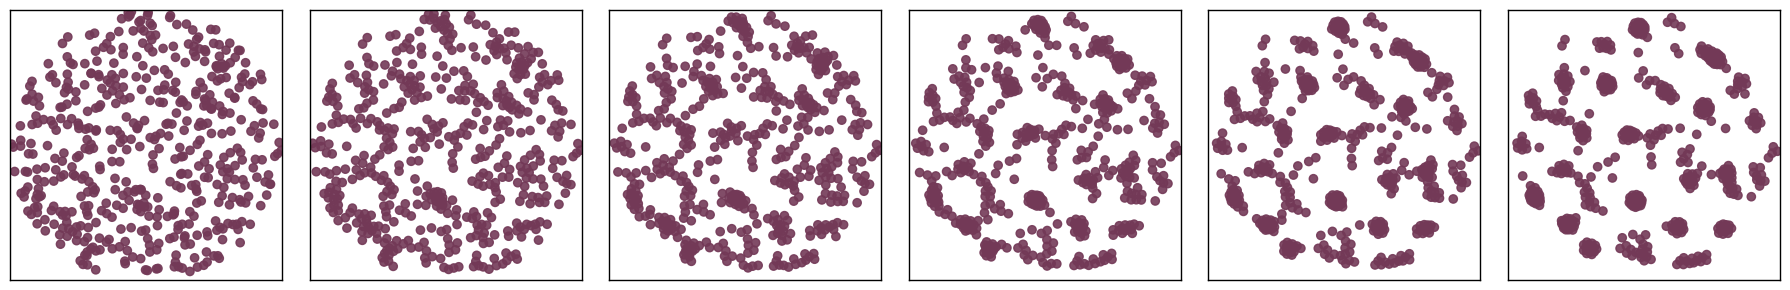

In [5]:
fig = swarm.plot_series(swarm.y[:,0], ntype='mod')

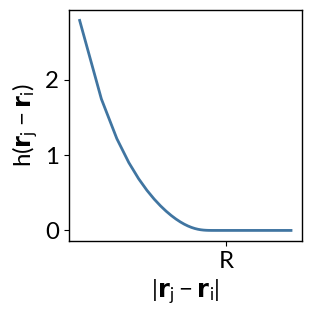

In [6]:
r = torch.linspace(0.05, swarm.L/2., 100)
fig, ax = plt.subplots(figsize=(3,3))
ax.plot(r, swarm.potential(r, swarm.rc), lw=2, color=cm.lapaz(100))
ax.set_xscale('log')
ax.minorticks_off()
ax.set_xticks([swarm.rc])
ax.set_xticklabels(['R'])
format_axis(ax, props, r'$|\mathbf{r}_j - \mathbf{r}_i|$', r'$h(\mathbf{r}_j - \mathbf{r}_i)$', ybins=4)
#fig.savefig(image_dir + 'swarm_potential.svg', bbox_inches='tight', transparent=True)

Detector: 64 x 64 	Probe: 9 x 9


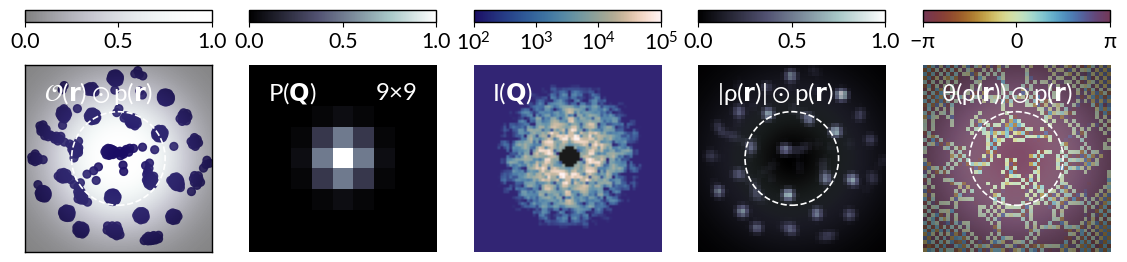

In [7]:
n = 48
dq = 0.75
f_probe = 0.25
f_mask = 0.05
c = [1.,0.]
lmax = 0
name = '_'.join([k + format_str(v) for (k,v) in zip(['n', 'dq', 'f', 'lmax'], [n, dq, f_probe, lmax])])

cxs = CXSPoint(swarm.R, n, L=swarm.L, dq=dq, f_probe=f_probe, f_mask=f_mask, c=c).to(device)
cxs.shapes()

if lmax:
    vmin = 10**(np.log10(lmax) - 3)
    vmax = lmax
else:
    vmin, vmax = 1e2, 1e5
fig = cxs.plot_example(swarm, swarm.y[-1,0], ntype='mod', lmax=lmax, vmin=vmin, vmax=vmax)
#fig.savefig(image_dir + 'swarm_example_' + name + '.png', bbox_inches='tight', dpi=400, transparent=True)

In [8]:
batch_time = T
batch_size = 1
t_batch, y0_batch, y_batch = swarm.get_batch(batch_time, batch_size)
print(' t:', t_batch.shape)
print('y0:', y0_batch.shape)
print(' y:', y_batch.shape)

cxs(y_batch)
t1 = time.time()
Y_batch = cxs(y_batch)

if lmax:
    Y_batch *= lmax/Y_batch.max()
    Y_batch = torch.poisson(Y_batch)
    
t2 = time.time()
print('Elapsed time: {:.3f} s'.format(t2 - t1))

 t: torch.Size([101])
y0: torch.Size([1, 500, 3])
 y: torch.Size([101, 1, 500, 3])
Elapsed time: 0.000 s


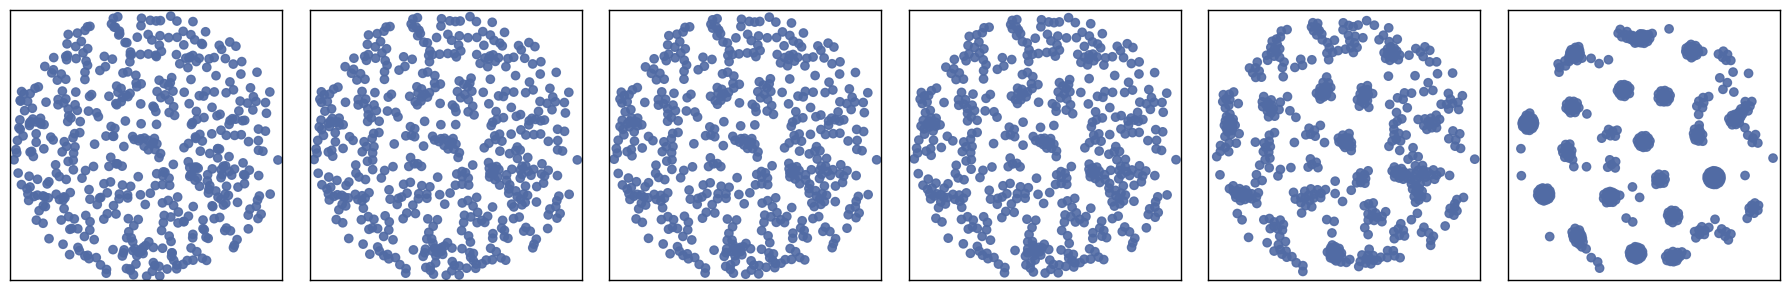

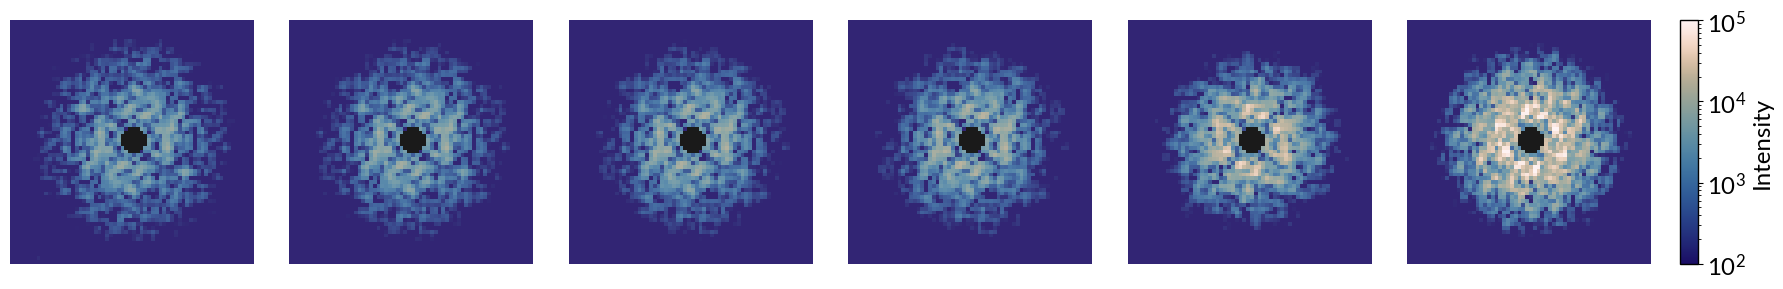

In [9]:
i_eval = swarm.get_eval(batch_time, n=6, d=5)

# change colors
c_mask = torch.zeros_like(y_batch[i_eval,0])
c_mask[...,-1] -= np.pi/3.

fig = swarm.plot_series(c_mask + y_batch[i_eval,0], ntype='mod')
#fig.savefig(image_dir + 'swarm_real_example.png', dpi=400, bbox_inches='tight', transparent=True)

fig = swarm.plot_series(Y_batch[i_eval,0].reshape(-1,cxs.n,cxs.n), ntype='log', vmin=vmin, vmax=vmax,
                        clabel='Intensity')

### Define neural ODE model

In [10]:
class NODE(ODEGraph):
    def __init__(self, args, method='dopri5', adjoint=False, default_type=torch.float64):
        super(NODE, self).__init__(method, adjoint, requires_grad=True, default_type=default_type)

        default_args = {'L': 5.,
                        'D': 2,
                        'R': 0.15,
                        'rc': 0.5,
                        'r0': 0.5,
                        'Nc': 500,
                        'fc': None,
                        'n': 64,
                        'dq': 0.75,
                        'f_probe': 0.25,
                        'f_mask': 0.05,
                        'c': [1.,0.],
                        'lmax': 0
                       }
        
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
        
        self.z = (2./self.L)**2
        self.basis = lambda x, a: (x, torch.sin(a), torch.cos(a))
        self.cxs = CXSPoint(self.R, self.n, L=self.L, dq=self.dq, f_probe=self.f_probe, f_mask=self.f_mask, c=self.c)
        
        if self.fc:
            self.F = nn.Sequential(
                nn.Linear(2,10),
                nn.Tanh(),
                nn.Linear(10,2)
            )
            self._message = self._message_t_ij
            
        else:
            self.mlp = nn.Sequential(
                nn.Linear(2,10),
                nn.LeakyReLU(),
                nn.Linear(10,10),
                nn.LeakyReLU(),
                nn.Linear(10,10),
                nn.LeakyReLU(),
                nn.Linear(10,10),
                nn.LeakyReLU(),
                nn.Linear(10,1),
                nn.Softplus()
            )
            self.F = self._F
            self._message = self._message_r_ij
            self.rc = nn.Parameter(torch.tensor(self.r0), requires_grad=True)
        
        self.gx = self._init_graph(self.rc, self.Nc)
        
    
    def _F(self, x, r):
        return self.mlp(torch.cat([x, r*torch.ones_like(x)], dim=-1))
    
    
    def _message_r_ij(self, x_ij, sint_ij, cost_ij, r_ij):
        d = self.F(r_ij, self.rc)
        m_ij = torch.cat((d*x_ij*(1. - d**(self.D - 1)), 0.*sint_ij), dim=-1)
        return m_ij
    
    
    def _message_t_ij(self, x_ij, sint_ij, cost_ij, r_ij):
        d = self.fc(r_ij, self.rc)
        f = self.F(torch.stack([cost_ij, sint_ij], dim=-1))
        m_ij = torch.cat((d*x_ij*(f[...,0] - d**(self.D - 1)), d*f[...,1]), dim=-1)
        return m_ij
    
        
    def message(self, x_i, x_j):
        y_ij = x_j - x_i
        x_ij, sint_ij, cost_ij = self.basis(*y_ij.split([self.D,1], dim=-1))
        r_ij = torch.sqrt(torch.bmm(x_ij.view(-1,1,self.D), x_ij.view(-1,self.D,1))).squeeze(-1)
        return self.z*self._message(x_ij, sint_ij, cost_ij, r_ij)
    
    
    def loss(self, y_pred, y_true):
        Y_true = self.cxs(y_true).flatten(start_dim=1)
        Y_pred = self.cxs(y_pred).flatten(start_dim=1)
        
        if self.lmax:
            # Scattering with poisson noise
            C = self.lmax/Y_true[0].max(dim=-1, keepdim=True)[0]
        
            Y_true = C*Y_true
            Y_pred = C*Y_pred
        
            Y_true = torch.poisson(Y_true)
        
            if self.lmax > 1.5e1:
                loss = nn.L1Loss()
            else:
                loss = nn.PoissonNLLLoss(log_input=False, eps=1e-8)
        else:
            # Ideal scattering
            loss = nn.L1Loss()
            
        return loss(Y_pred, Y_true)
        
        
    def forward(self, t, y):
        size = y.shape
        data = Batch.from_data_list([Data(x=y[i], pos=y[i,...,:-1]) for i in range(size[0])])
        data.edge_index = self.gx(data.pos, data.batch)
        dy = super().forward(data.x, data.edge_index)
        return dy.view(size)

In [11]:
method = 'dopri5'
adjoint = False
args = {'L': swarm.L,
        'D': swarm.D,
        'R': swarm.R,
        'rc': swarm.rc,
        'r0': 0.95,
        'Nc': swarm.Nc,
        'fc': None,
        'n': 48,
        'dq': 0.75,
        'f_probe': 0.25,
        'f_mask': 0.05,
        'lmax': 0
       }

#torch.manual_seed(0)

node = NODE(args, method, adjoint, default_type).to(device)
node.cxs.shapes()
optimizer = optim.Adam(node.parameters(), lr=1e-3)

Detector: 64 x 64 	Probe: 9 x 9


In [12]:
model_path = 'T' + str(tf) + '_' + '_'.join(
    k.replace('_','') + format_str(v) for (k,v) in args.items() if isinstance(v, (int,float)))
image_path = image_dir + model_path + '/'
model_path = model_dir + model_path + '_0.torch'

if not os.path.exists(image_path):
    os.makedirs(image_path)
    
print(image_path)
print(model_path)

_images/T10_L5p0_D2_R0p15_rc0p75_r00p95_Nc500_n48_dq0p75_fprobe0p25_fmask0p05_lmax0/
_models/T10_L5p0_D2_R0p15_rc0p75_r00p95_Nc500_n48_dq0p75_fprobe0p25_fmask0p05_lmax0_0.torch


### Train model

In [13]:
class EMA(object):
    def __init__(self, momentum=0.02):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.value = None
        self.avg = 0

    def update(self, value):
        if self.value is None:
            self.avg = value
        else:
            self.avg = self.avg*(1 - self.momentum) + value*self.momentum
        self.value = value

ema = EMA()

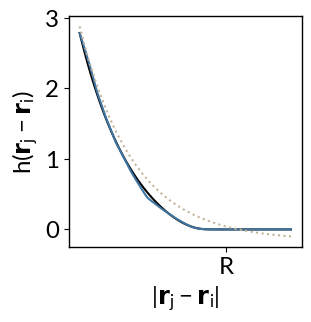

In [14]:
tprops = props.copy()
tprops.set_size(props.get_size()-2)

try: saved = torch.load(model_path)
except:
    chkpt = 5
    loss = []
    kernel = []
else:
    chkpt = saved['chkpt']
    loss = saved['loss']
    kernel = saved['kernel']
    node.load_state_dict(saved['state'])
    node.to(device)
    optimizer.load_state_dict(saved['optimizer'])
    ema.update(loss[-1]/ema.momentum)
    
if node.fc:
    t_ij = torch.linspace(-np.pi,np.pi,100)
    arg = torch.stack([torch.cos(t_ij), torch.sin(t_ij)], dim=-1).to(device)
else:
    r_ij = torch.logspace(np.log10(0.05), np.log10(swarm.L/2.), 100)
    fig, ax = plt.subplots(figsize=(3,3))
    ax.plot(r_ij, swarm.potential(r_ij, swarm.rc), color='black', label='True')
    ax.plot(r_ij, node.F(r_ij.view(-1,1).to(device), node.rc).detach().cpu(), color=cm.lapaz(100), label='Pred.')
    ax.plot(r_ij, node.z*(node.r0 - r_ij)/r_ij, ls=':', color=cm.lapaz(200), label='Init. target')
    ax.set_xscale('log')
    ax.minorticks_off()
    ax.set_xticks([swarm.rc])
    ax.set_xticklabels(['R'])
    format_axis(ax, props, r'$|\mathbf{r}_j - \mathbf{r}_i|$', r'$h(\mathbf{r}_j - \mathbf{r}_i)$', ybins=4)
    #fig.savefig(image_path + 'swarm_potential_untrained.svg', bbox_inches='tight', transparent=True)

    try: saved = torch.load(model_path)
    except: 
        # Pre-train
        max_iters = 500
        r_batch = r_ij.view(-1,1).to(device)
        for k in range(1, max_iters + 1):
            optimizer.zero_grad()  
            _loss = torch.abs(node.F(r_batch.to(device), node.rc) - node.z*(node.r0 - r_batch)/r_batch).sum()
            _loss.backward()
            optimizer.step()

        fig, ax = plt.subplots(figsize=(3,3))
        ax.plot(r_ij, swarm.potential(r_ij, swarm.rc), color='black', label='True')
        ax.plot(r_ij, node.F(r_ij.view(-1,1).to(device), node.rc).detach().cpu(), color=cm.lapaz(100), label='Pred.')
        ax.plot(r_ij, node.z*(node.r0 - r_ij)/r_ij, ls=':', color=cm.lapaz(200), label='Init. target')
        ax.set_xscale('log')
        ax.minorticks_off()
        ax.set_xticks([swarm.rc])
        ax.set_xticklabels(['R'])
        format_axis(ax, props, r'$|\mathbf{r}_j - \mathbf{r}_i|$', r'$h(\mathbf{r}_j - \mathbf{r}_i)$', ybins=4)
        ax.legend(frameon=False, prop=tprops)
        #fig.savefig(image_path + 'swarm_potential_pretrained.svg', bbox_inches='tight', transparent=True)
        print('rc:', node.rc.item())

In [ ]:
node.train()
max_iters = 115
warmup_iters = 2*chkpt
batch_time = 20
batch_size = 4
f_spike = 2

end = time.time()
j = f_spike
for k in range(1, max_iters + 1):
    optimizer.zero_grad()
    
    t_batch, y0_batch, y_batch = swarm.get_batch(batch_time, batch_size)
    y_pred = node.solve(t_batch, y0_batch, device, rtol=1e-6, atol=1e-6)
    _loss = node.loss(y_pred, y_batch)

    if (k > warmup_iters + 1) and (_loss.item() > (j + 1)*ema.avg):
        print('Restart: Loss:', _loss.item(), 'EMA:', ema.avg)
        saved = torch.load(model_path)
        chkpt = saved['chkpt']
        loss = saved['loss']
        kernel = saved['kernel']
        node.load_state_dict(saved['state'])
        node.to(device)
        optimizer.load_state_dict(saved['optimizer'])
        optimizer.param_groups[0]['lr'] /= 2.
        j += 1
    
    else:
        j = f_spike
        if k > warmup_iters:
            ema.update(_loss.item())

        _loss.backward()
        optimizer.step()

        if k % chkpt == 0:
            with torch.no_grad():
                loss.append(_loss.item())
                if node.fc:
                    kernel.append(node.F(arg).detach().cpu())
                else:
                    kernel.append(node.F(r_ij.view(-1,1).to(device), node.rc).detach().cpu())
                print('Iteration: {:04d} | Total Loss: {:.6e} | Time: {:.6f}'.format(
                    k, _loss.item(), time.time() - end)) 
        
        if k % (10*chkpt) == 0:
            torch.save({
                'state': node.state_dict(),
                'optimizer': optimizer.state_dict(),
                'chkpt': chkpt,
                'loss': loss,
                'kernel': kernel,
            }, model_path)

    end = time.time()

In [27]:
torch.save({
    'state': node.state_dict(),
    'optimizer': optimizer.state_dict(),
    'chkpt': chkpt,
    'loss': loss,
    'kernel': kernel,
}, model_path)

rc: 0.8317644000053406


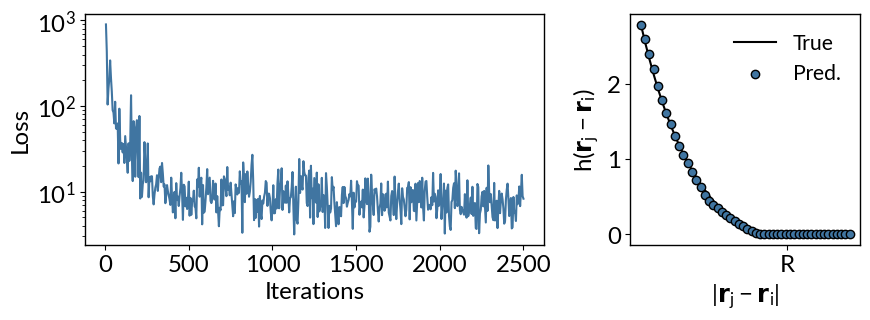

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,3), gridspec_kw={'width_ratios':[1,0.5]})
fig.subplots_adjust(wspace=0.25)
ax[0].plot(chkpt*np.arange(1,len(loss)+1), loss, color=cm.lapaz(100))
ax[0].set_yscale('log')
format_axis(ax[0], props, 'Iterations', 'Loss', ybins=4)

if node.fc:
    kernel_true = torch.stack([1 + swarm.J*torch.cos(t_ij), swarm.K*torch.sin(t_ij)], dim=-1)
    ax[1].plot(kernel_true[:,0], kernel_true[:,1], color='black', ls='dashed')
    ax[1].plot(kernel[-1][:,0], kernel[-1][:,1], color=cm.lapaz(100))
    format_axis(ax[1], props, r'$U_1(\theta_j-\theta_i)$', r'$U_2(\theta_j-\theta_i)$', xbins=4, ybins=4)
else:
    print('rc:', node.rc.item())
    ax[1].plot(r_ij[::2], swarm.potential(r_ij[::2], swarm.rc), color='black', label='True')
    ax[1].scatter(r_ij[::2], kernel[-1][::2], color=cm.lapaz(100), ec='black', zorder=10, label='Pred.')
    ax[1].set_xscale('log')
    ax[1].minorticks_off()
    ax[1].set_xticks([swarm.rc])
    ax[1].set_xticklabels(['R'])
    ax[1].legend(frameon=False, prop=tprops)
    format_axis(ax[1], props, r'$|\mathbf{r}_j - \mathbf{r}_i|$', r'$h(\mathbf{r}_j - \mathbf{r}_i)$', ybins=4)
#fig.savefig(image_path + 'swarm_history.png', dpi=400, bbox_inches='tight', transparent=True)

### Evaluate model

In [16]:
node.eval()
batch_time = T
i_eval = swarm.get_eval(batch_time, n=6, d=5)
t_eval = np.round(swarm.t[i_eval].numpy(), decimals=1)

with torch.no_grad():
    t_batch, y0_batch, y_batch = swarm.get_batch(batch_time, 1)
    y_pred = node.solve(t_batch, y0_batch, device, rtol=1e-6, atol=1e-6)
    y_diff = y_pred - y_batch
    
    Y_batch = node.cxs(y_batch[i_eval,0]).reshape(-1,node.cxs.n,node.cxs.n)
    Y_pred = node.cxs(y_pred[i_eval,0]).reshape(-1,node.cxs.n,node.cxs.n)
    
    if node.lmax:
        Y_batch *= node.lmax/Y_batch.max()
        Y_batch = torch.poisson(Y_batch)
        Y_pred *= node.lmax/Y_pred.max()
    
    Y_diff = Y_pred - Y_batch

Elapsed time: 0.31 s


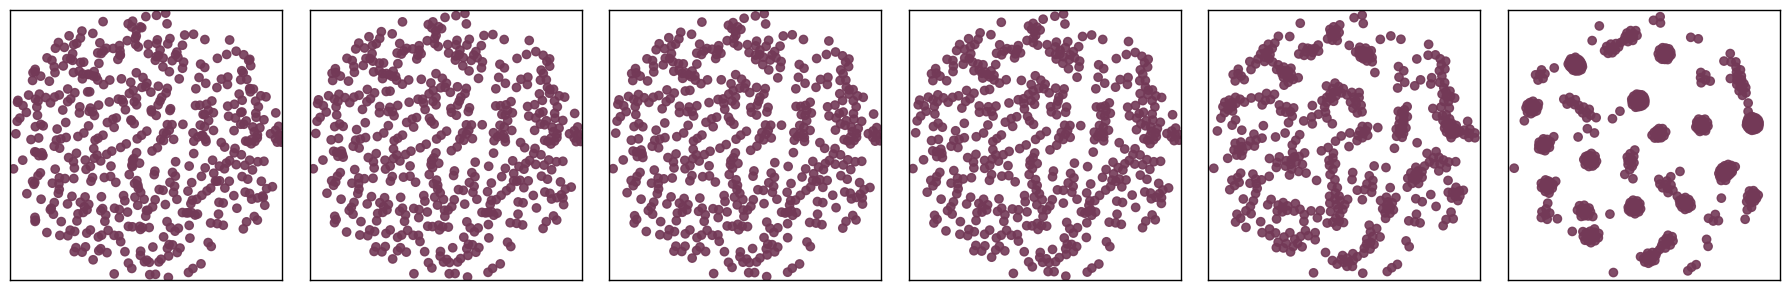

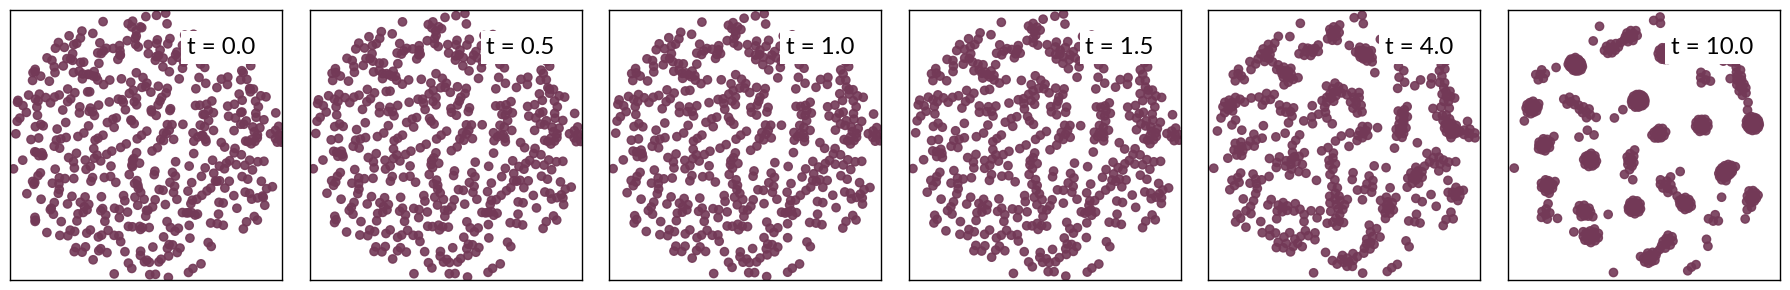

In [17]:
fig = node.plot_series(y_batch[i_eval,0], ntype='mod')
fig = node.plot_series(y_pred[i_eval,0], ntype='mod')

for i, ax in enumerate(fig._localaxes[-7:]):
    ax.text(0.9, 0.9, 't = ' + str(t_eval[i]), ha='right', va='top', fontproperties=props, transform=ax.transAxes,
            bbox=dict(fc='white', ec='none'))

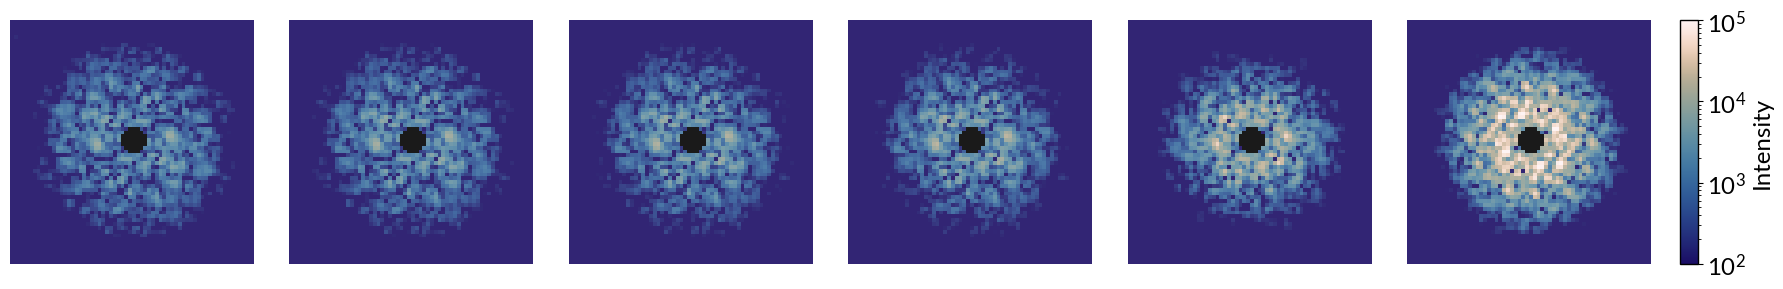

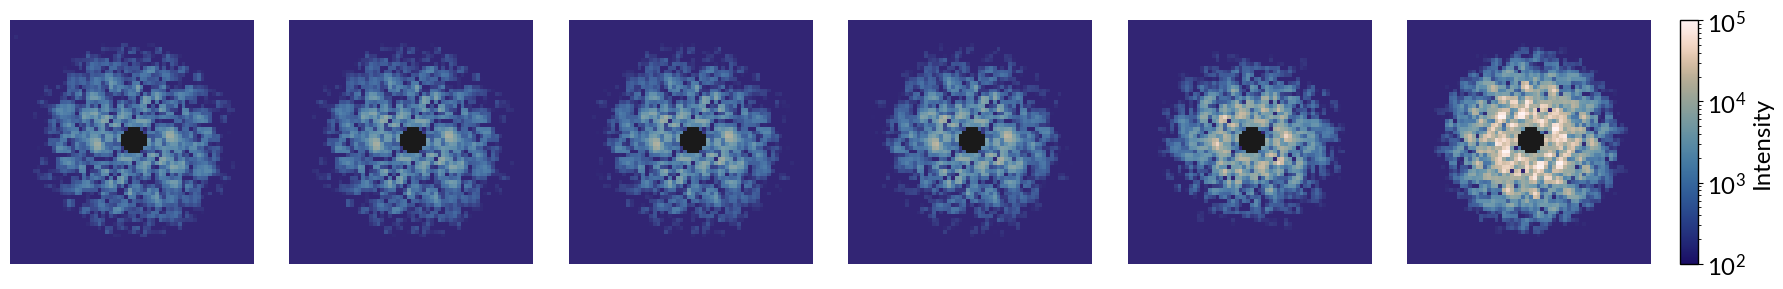

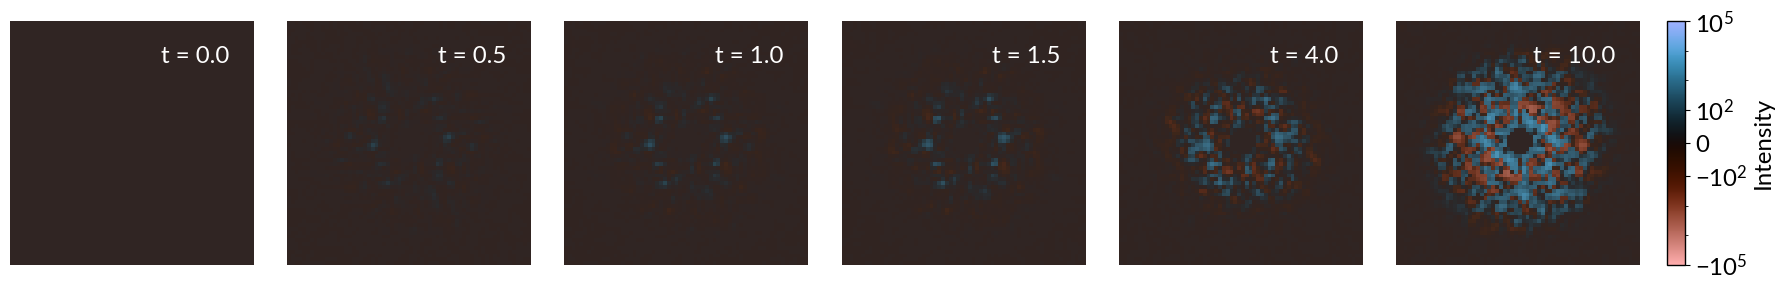

In [18]:
if node.lmax:
    vmin, vmax = 10**(np.log10(node.lmax)-3), node.lmax
else:
    vmin, vmax = 1e2, 1e5
    
fig = node.plot_series(Y_batch, ntype='log', clabel='Intensity', vmin=vmin, vmax=vmax)
fig = node.plot_series(Y_pred, ntype='log', clabel='Intensity', vmin=vmin, vmax=vmax)
fig = node.plot_series(Y_diff, ntype='symlog', clabel='Intensity', vmin=vmin, vmax=vmax)
for i, ax in enumerate(fig._localaxes[-7:-1]):
    ax.text(0.9, 0.9, 't = ' + str(t_eval[i]), color='white', ha='right', va='top',
            fontproperties=props, transform=ax.transAxes)

### Extrapolate model

In [19]:
M = 5

swarm.init_state(M)
swarm.to(device)

tf = 50
T = 10*tf + 1
t = torch.linspace(0, tf, T)
print('T:', T)

swarm.solve(t, device=device, rtol=1e-6, atol=1e-6)

T: 501
Elapsed time: 3.10 s


In [20]:
node.eval()
batch_time = T
i_eval = np.array([0,20,50,100,250,500])
t_eval = np.round(swarm.t[i_eval].numpy()).astype(int)

with torch.no_grad():
    t_batch, y0_batch, y_batch = swarm.get_batch(batch_time, 1)
    y_pred = node.solve(t_batch, y0_batch, device, rtol=1e-6, atol=1e-6)
    y_diff = y_pred - y_batch
    
    Y_batch = node.cxs(y_batch[:,0]).reshape(-1,node.cxs.n,node.cxs.n)
    Y_pred = node.cxs(y_pred[:,0]).reshape(-1,node.cxs.n,node.cxs.n)
    
    if node.lmax:
        Y_batch *= node.lmax/Y_batch.max()
        Y_batch = torch.poisson(Y_batch)
        Y_pred *= node.lmax/Y_pred.max()
    
    Y_diff = Y_pred - Y_batch

Elapsed time: 2.11 s


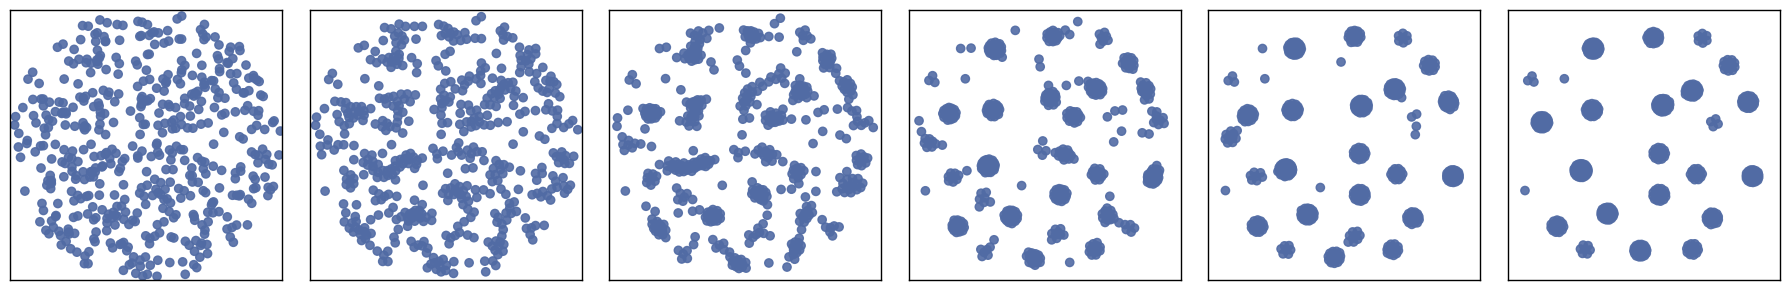

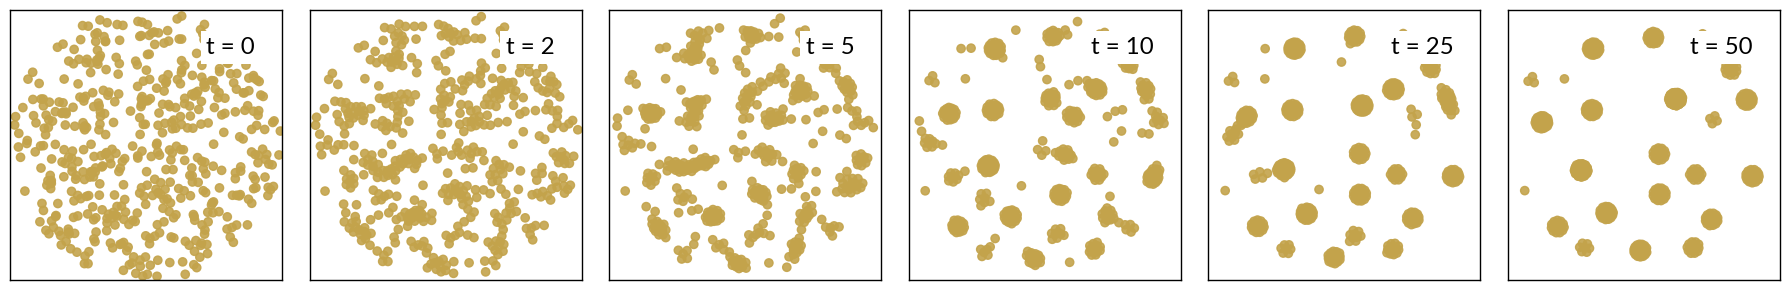

In [21]:
c_mask = torch.zeros_like(y_batch[i_eval,0])
c_mask[...,-1] -= np.pi/3.

fig = node.plot_series(c_mask + y_batch[i_eval,0], ntype='mod')
#fig.savefig(image_path + 'swarm_real_true.png', dpi=400, bbox_inches='tight', transparent=True)

c_mask[...,-1] -= np.pi

fig = node.plot_series(c_mask + y_pred[i_eval,0], ntype='mod')
for i, ax in enumerate(fig._localaxes[-7:]):
    ax.text(0.9, 0.9, 't = ' + str(t_eval[i]), ha='right', va='top', fontproperties=props, transform=ax.transAxes,
            bbox=dict(fc='white', ec='none'))
#fig.savefig(image_path + 'swarm_real_pred.png', dpi=400, bbox_inches='tight', transparent=True)

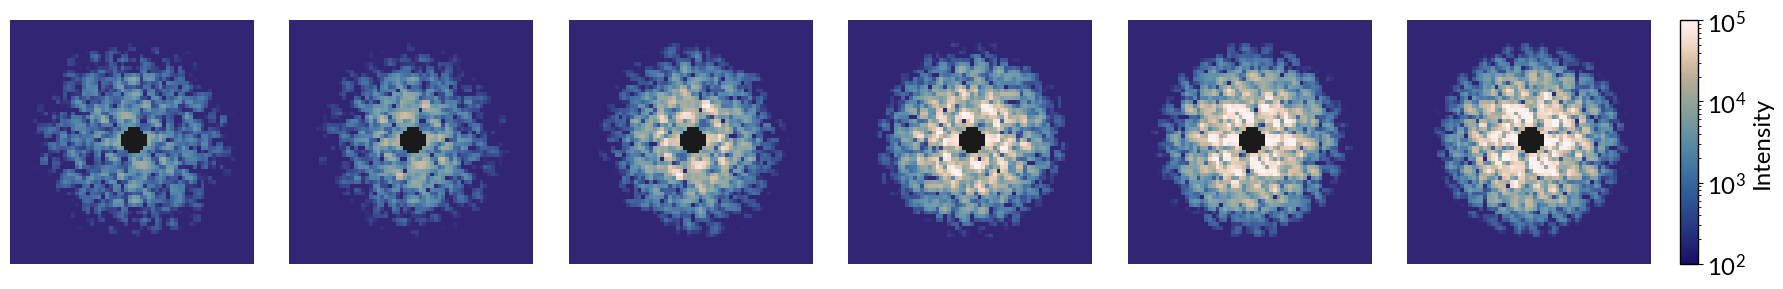

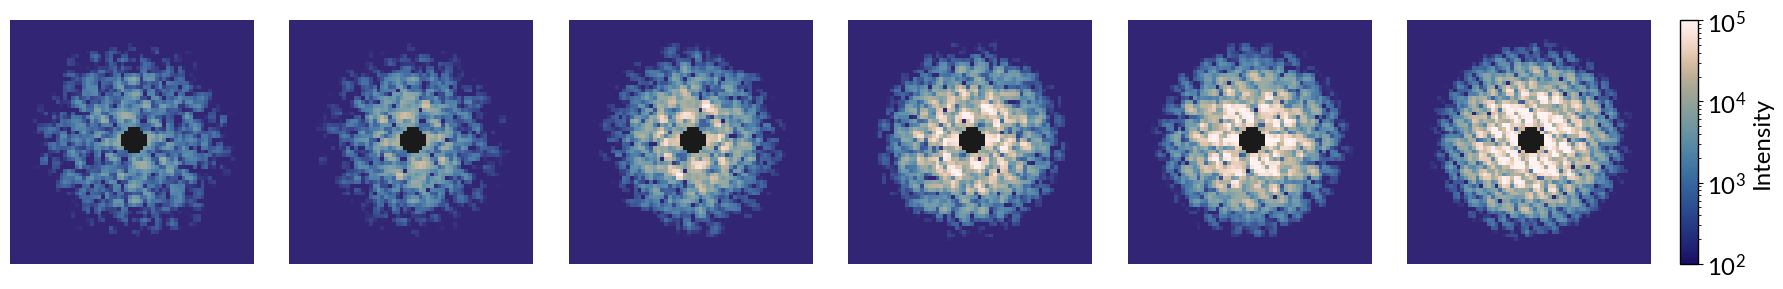

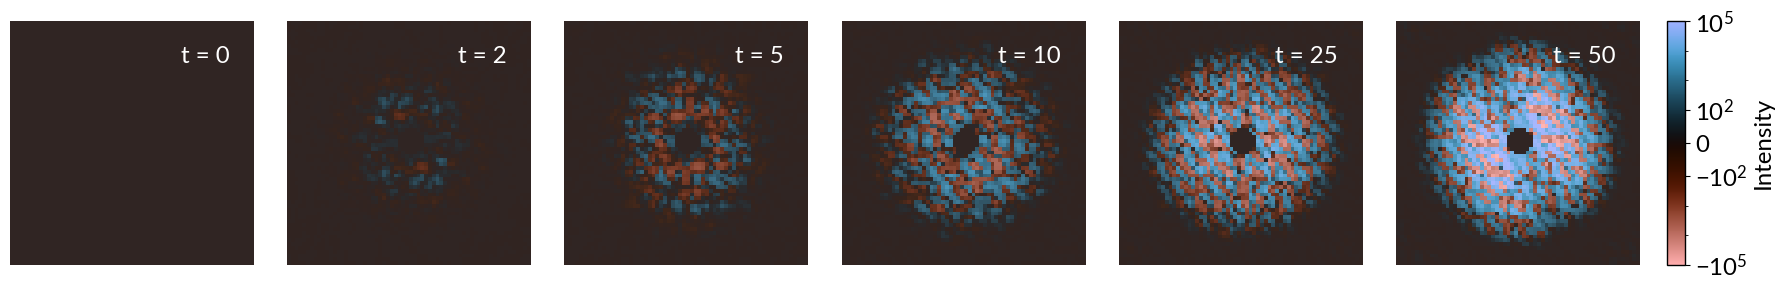

In [22]:
if node.lmax:
    vmin, vmax = 10**(np.log10(node.lmax)-3), node.lmax
else:
    vmin, vmax = 1e2, 1e5
    
fig = node.plot_series(Y_batch[i_eval], ntype='log', clabel='Intensity', vmin=vmin, vmax=vmax)
#fig.savefig(image_path + 'swarm_fourier_true.png', dpi=400, bbox_inches='tight', transparent=True)

fig = node.plot_series(Y_pred[i_eval], ntype='log', clabel='Intensity', vmin=vmin, vmax=vmax)
#fig.savefig(image_path + 'swarm_fourier_pred.png', dpi=400, bbox_inches='tight', transparent=True)

fig = node.plot_series(Y_diff[i_eval], ntype='symlog', clabel='Intensity', vmin=vmin, vmax=vmax)
for i, ax in enumerate(fig._localaxes[-7:-1]):
    ax.text(0.9, 0.9, 't = ' + str(t_eval[i]), color='white', ha='right', va='top',
            fontproperties=props, transform=ax.transAxes)
#fig.savefig(image_path + 'swarm_fourier_diff.png', dpi=400, bbox_inches='tight', transparent=True)

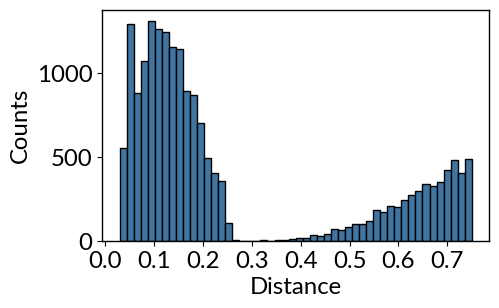

In [23]:
dist = Distance(norm=False)
data = Batch.from_data_list([Data(x=y_batch[-1,0], pos=y_batch[-1,0,...,:-1])])
data.edge_index = swarm.gx(data.pos, data.batch)
dist(data)

fig, ax = plt.subplots(figsize=(5,3))
ax.hist(data.edge_attr.cpu().view(-1).tolist(), color=cm.lapaz(100), ec='black', bins=50)
format_axis(ax, props=props, xlabel='Distance', ylabel='Counts', ybins=4)

Text(0.09, 0.5, 'Counts')

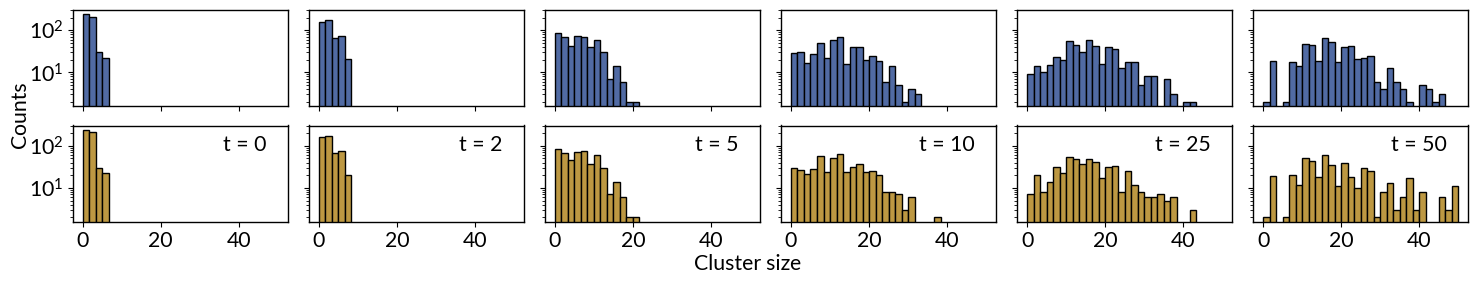

In [24]:
d = 0.15
n_bins = 30
n = len(t_eval)
gx = swarm._init_graph(d, swarm.Nc)

tprops = props.copy()
tprops.set_size(props.get_size()-2)
fig, ax = plt.subplots(2, n, figsize=(3*n,2.75), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1)
for i in range(n-1,-1,-1):
    data = Batch.from_data_list([Data(x=y_batch[i_eval[i],0], pos=y_batch[i_eval[i],0,...,:-1])])
    data.edge_index = gx(data.pos, data.batch)
    
    data_pred = Batch.from_data_list([Data(x=y_pred[i_eval[i],0], pos=y_pred[i_eval[i],0,...,:-1])])
    data_pred.edge_index = gx(data_pred.pos, data_pred.batch)
    
    if i == (n - 1):
        _, bins, _ = ax[0,i].hist(degree(data.edge_index[0]).cpu(), bins=n_bins, fc=cm.romaO(213), ec='black',
                                  log=True)
    else:
        ax[0,i].hist(degree(data.edge_index[0]).cpu(), bins=bins, fc=cm.romaO(213), ec='black')
    ax[1,i].hist(degree(data_pred.edge_index[0]).cpu(), bins=bins, fc=cm.romaO(80), ec='black')
    ax[1,i].text(0.9, 0.9, 't = ' + str(t_eval[i]), color='black', ha='right', va='top', fontproperties=tprops,
                 transform=ax[1,i].transAxes)
    
    format_axis(ax[0,i], tprops)
    format_axis(ax[1,i], tprops)
fig.supxlabel('Cluster size', fontproperties=tprops, y=-0.08)
fig.supylabel('Counts', fontproperties=tprops, x=0.09)
#fig.savefig(image_path + 'swarm_distribution.svg', bbox_inches='tight', transparent=True)